In [4]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [5]:
s = []
prefix = "HH_client_ATTP_"
num_files = 7
for i in range(num_files):
    s.append(open("test-client-id-all-stats-0%d.txt" % i, "r").readlines())
s.append(open("test-client-id-all-stats.txt", "r").readlines())    

In [6]:
raw_pr = []
raw_mem = []
raw_time = []
for i in range(len(s)):
    ln = 0
    query_type = ""
    for line in s[i]:
        if line.startswith("Stats request at line"):
            ln = int(re.search("\d+", line).group())
        if line.find(" timers") != -1:
            query_type = line.strip().split(" ")[0]
        if line.find(" ms = ") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                sketch = [sketch[0], ''.join(sketch[1:])]
                raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
        if line.find("prec") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                sketch = [sketch[0], ''.join(sketch[1:])]
                pr_info = t[1].split(",")
                try:
                    pr_info = list(map(lambda x: eval(x.split('=')[1].strip()), pr_info))
                except ZeroDivisionError:
                    continue
                raw_pr.append(sketch + ["Precision", pr_info[0]])
                raw_pr.append(sketch + ["Recall", pr_info[1]])
        if line.find("MB") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                t = [sketch[0], ''.join(sketch[1:]), ln, int(t[1].split("=")[0].strip()[:-2])]
                raw_mem.append(t)

In [7]:
mem_df = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage"])
mem_df

,Sketch,Param,Stream Size,Memory Usage
0,SAMPLING,ss100000,13528042,25606560
1,PCM_HH,logU23e0.000137d0.01D2000,13528042,359640536
2,SAMPLING,ss100000,27056084,25610912
3,PCM_HH,logU23e0.000137d0.01D2000,27056084,364290072
4,SAMPLING,ss100000,40584126,25617056
...,...,...,...,...
2220,CMG,e0.000060,1352804200,69106040
2221,CMG,e0.000080,1352804200,53346680
2222,SAMPLING,ss51800,0,14008736
2223,PCM_HH,logU23e0.000137d0.001D2000,0,1470202152


In [8]:
time_df = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Value"])
time_df_processed = pd.merge(time_df, mem_df, on = ["Sketch", "Param", "Stream Size"]).drop_duplicates()
update_time_df = time_df_processed[time_df_processed["Type"] == "Update"]
update_time_df

,Sketch,Param,Stream Size,Type,Value,Memory Usage
0,SAMPLING,ss100000,13528042,Update,1239,25606560
2,PCM_HH,logU23e0.000137d0.01D2000,13528042,Update,59498,359640536
4,SAMPLING,ss100000,27056084,Update,2424,25610912
6,PCM_HH,logU23e0.000137d0.01D2000,27056084,Update,121875,364290072
8,SAMPLING,ss100000,40584126,Update,3621,25617056
...,...,...,...,...,...,...
6576,CMG,e0.000040,1352804200,Update,635726,104658104
6584,CMG,e0.000080,1352804200,Update,602572,53346680
6592,SAMPLING,ss51800,0,Update,206230,14008736
6594,PCM_HH,logU23e0.000137d0.001D2000,0,Update,23861129,1470202152


In [9]:
pr_df = pd.DataFrame(raw_pr, columns = ["Sketch", "Param", "Metric", "Value"])
pr_df

,Sketch,Param,Metric,Value
0,SAMPLING,ss100000,Precision,0.818182
1,SAMPLING,ss100000,Recall,0.873786
2,SAMPLING,ss100000,Precision,0.852941
3,SAMPLING,ss100000,Recall,0.852941
4,PCM_HH,logU23e0.000137d0.01D2000,Precision,0.571429
...,...,...,...,...
247,SAMPLING,ss51800,Recall,0.772152
248,PCM_HH,logU23e0.000137d0.001D2000,Precision,0.600760
249,PCM_HH,logU23e0.000137d0.001D2000,Recall,1.000000
250,CMG,e0.000040,Precision,0.981366


In [10]:
last_mem_df = mem_df.groupby(["Sketch", "Param"]).agg({"Memory Usage": "max"})
last_mem_df

Memory Usage
Sketch   Param                                   
CMG      e0.000010                      437017360
         e0.000020                      210152440
         e0.000040                      104658104
         e0.000060                       69106040
         e0.000080                       53346680
         e0.000100                       44464400
         e0.000200                       25489968
         e0.000600                       43331240
PCM_HH   logU23e0.000137d0.001D2000    1470202152
         logU23e0.000137d0.01D2000     1048756216
         logU23e0.000137d0.05D2000      629325768
         logU23e0.001d0.01D2000         751634044
         logU23e0.002d0.01D2000         660432720
         logU23e0.002d0.05D2000         398079792
SAMPLING ss10000                          2920096
         ss100000                        26459552
         ss1000000                      256819616
         ss200000                        52149152
         ss500000                       128909984
         ss51800                         14008736

In [11]:
pr_df_processed = pd.DataFrame(pd.merge(pr_df, last_mem_df, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage", "Metric"]).mean().to_records())
pr_df_processed

,Sketch,Param,Memory Usage,Metric,Value
0,CMG,e0.000010,437017360,Precision,0.994719
1,CMG,e0.000010,437017360,Recall,0.994581
2,CMG,e0.000020,210152440,Precision,0.991703
3,CMG,e0.000020,210152440,Recall,0.981317
4,CMG,e0.000040,104658104,Precision,0.978909
5,CMG,e0.000040,104658104,Recall,0.984984
6,CMG,e0.000060,69106040,Precision,0.977794
7,CMG,e0.000060,69106040,Recall,0.981638
8,CMG,e0.000080,53346680,Precision,0.989320
9,CMG,e0.000080,53346680,Recall,0.964672


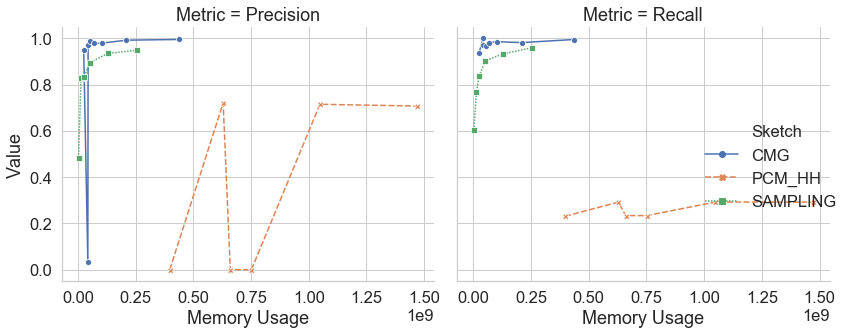

In [12]:
g = sns.relplot(x="Memory Usage", y="Value", hue="Sketch", style = "Sketch", col = "Metric", kind = "line",  markers=True,data=pr_df_processed)
plt.tight_layout()
plt.savefig(prefix + 'pr.pdf')

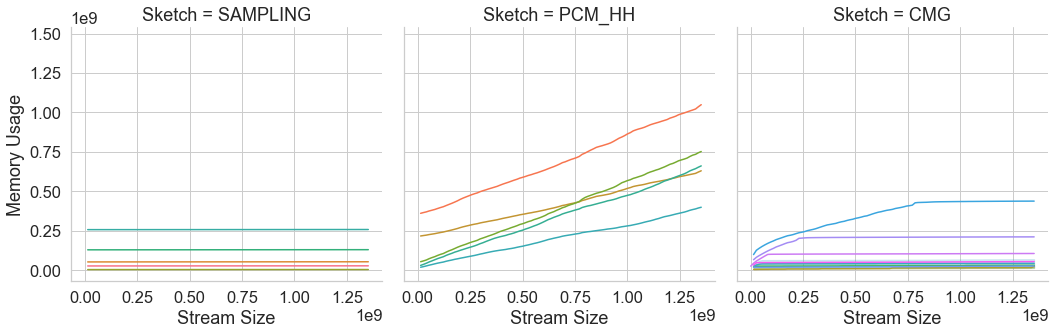

In [13]:
g = sns.relplot(x="Stream Size", y="Memory Usage", hue="Param", data=mem_df, dashes = False, col="Sketch",
                kind="line", legend=False)
plt.tight_layout()
plt.savefig(prefix + 'mem.pdf')

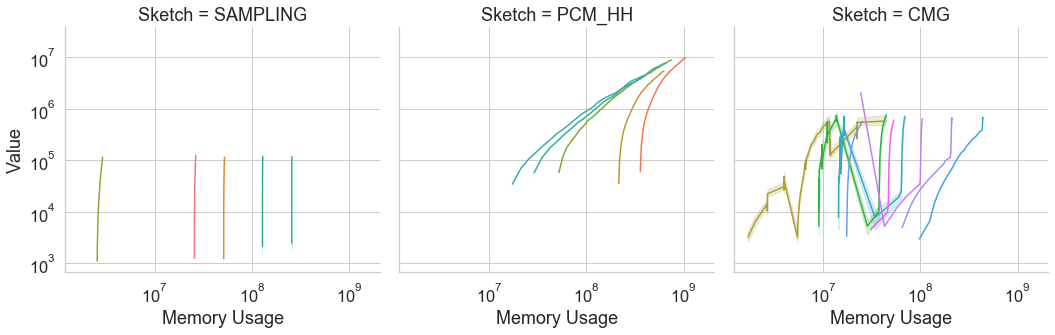

In [14]:
g = sns.relplot(x="Memory Usage", y="Value", hue="Param", style = "Param", col = "Sketch", kind = "line",  dashes = False, data=update_time_df, legend = False)
g.set(xscale = "log", yscale="log")
plt.tight_layout()
plt.savefig(prefix + 'time.pdf')

In [15]:
update_time_df[update_time_df.Sketch == "SAMPLING"]

,Sketch,Param,Stream Size,Type,Value,Memory Usage
0,SAMPLING,ss100000,13528042,Update,1239,25606560
4,SAMPLING,ss100000,27056084,Update,2424,25610912
8,SAMPLING,ss100000,40584126,Update,3621,25617056
12,SAMPLING,ss100000,54112168,Update,4810,25625504
16,SAMPLING,ss100000,67640210,Update,5986,25630880
...,...,...,...,...,...,...
5478,SAMPLING,ss1000000,1312220074,Update,113543,256790944
5490,SAMPLING,ss1000000,1325748116,Update,114685,256800672
5502,SAMPLING,ss1000000,1339276158,Update,115832,256810144
5514,SAMPLING,ss1000000,1352804200,Update,117023,256819616
